In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages
!pip install tensorflow scikit-learn opencv-python
!pip install torch torchvision
!git clone https://github.com/ultralytics/yolov5  # YOLOv5 repo
%cd yolov5
!pip install -r requirements.txt  # Install requirements


Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 31.53 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 17.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

# Check if TensorFlow can access a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from collections import Counter
from glob import glob

# Define directories and general prefix selection
features_dir = '/content/drive/MyDrive/results_2b/'
img_dir = '/content/drive/MyDrive/485Fashion'
output_dir = '/content/drive/MyDrive/clustering_results_3/'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load pretrained model for labeling
labeling_model = ResNet50(weights="imagenet")

# Load all feature files in directory and filter if necessary
features_files = glob(f'{features_dir}*_features.npy')
print("Feature files detected:", features_files)

# Initialize DataFrame for results
results_df = pd.DataFrame(columns=["Model", "Algorithm", "Params", "Silhouette", "Davies-Bouldin"])

# Function to generate cluster names
def generate_cluster_names(labels, img_names, img_dir, model, sample_size=48, confidence_threshold=0.7):
    cluster_names = {}
    for cluster_label in np.unique(labels):
        cluster_indices = np.where(labels == cluster_label)[0]
        predictions = []

        for idx in cluster_indices[:sample_size]:
            # Remove any '_object_x' suffix from the image name
            img_base_name = img_names[idx].split('_object')[0]
            img_path = os.path.join(img_dir, img_base_name)

            # Ensure the image file exists before proceeding
            if not os.path.exists(img_path):
                print(f"Image file not found: {img_path}")
                continue

            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
            preds = model.predict(img_array)
            decoded_preds = decode_predictions(preds, top=2)[0]

            # Filter predictions by confidence threshold
            for label, description, confidence in decoded_preds:
                if confidence >= confidence_threshold:
                    predictions.append(description)

        # Select the top 2 or 3 most common predictions to name the cluster
        top_labels = [label for label, count in Counter(predictions).most_common(2)]
        cluster_names[cluster_label] = ', '.join(top_labels)

    return cluster_names

# Clustering and evaluation with PCA 50 components
for feature_file in features_files:
    model_name = os.path.basename(feature_file).split('_features')[0]
    features = np.load(feature_file)
    img_names_file = f"{features_dir}{model_name}_img_names.npy"

    # Check and load corresponding image names
    if os.path.exists(img_names_file):
        img_names = np.load(img_names_file)
    else:
        print(f"Image names file not found for {model_name}")
        continue

    # Apply PCA with n_components=50
    n_components = 50
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Optional t-SNE transformation for visualization purposes
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features_pca)

    # Apply KMeans clustering with reduced random_state
    kmeans = KMeans(n_clusters=10, random_state=21)
    kmeans.fit(features_tsne)
    labels = kmeans.labels_
    silhouette = silhouette_score(features_tsne, labels) if len(set(labels)) > 1 else None
    davies_bouldin = davies_bouldin_score(features_tsne, labels) if len(set(labels)) > 1 else None

    # Save evaluation results
    results_df = pd.concat([results_df, pd.DataFrame([{
        "Model": model_name,
        "PCA Components": n_components,
        "Algorithm": "KMeans",
        "Params": kmeans.get_params(),
        "Silhouette": silhouette,
        "Davies-Bouldin": davies_bouldin
    }])], ignore_index=True)

    # Generate cluster names based on content
    cluster_names = generate_cluster_names(labels, img_names, img_dir, labeling_model)

    # Save labels and cluster names with unique filenames for PCA 50
    np.save(f"{output_dir}{model_name}_PCA{n_components}_labels.npy", labels)
    np.save(f"{output_dir}{model_name}_PCA{n_components}_cluster_names.npy", cluster_names)

    print(f"Saved clustering results for {model_name} with PCA={n_components}")

# Save results to CSV for easy access
results_df.to_csv(f"{output_dir}clustering_evaluation_results.csv", index=False)
print(f"Clustering Evaluation Results saved to '{output_dir}clustering_evaluation_results.csv'.")

Feature files detected: ['/content/drive/MyDrive/results_2b/ResNet50_imagenet_20241109-161234_features.npy', '/content/drive/MyDrive/results_2b/ResNet50_None_20241109-161327_features.npy', '/content/drive/MyDrive/results_2b/VGG16_imagenet_20241109-161419_features.npy', '/content/drive/MyDrive/results_2b/VGG16_None_20241109-161510_features.npy', '/content/drive/MyDrive/results_2b/InceptionV3_imagenet_20241109-161609_features.npy', '/content/drive/MyDrive/results_2b/InceptionV3_None_20241109-161707_features.npy']


<ipython-input-21-6f5b4429e715>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

Feature files detected for visualization: ['/content/drive/MyDrive/results_2b/ResNet50_imagenet_20241109-161234_features.npy', '/content/drive/MyDrive/results_2b/ResNet50_None_20241109-161327_features.npy', '/content/drive/MyDrive/results_2b/VGG16_imagenet_20241109-161419_features.npy', '/content/drive/MyDrive/results_2b/VGG16_None_20241109-161510_features.npy', '/content/drive/MyDrive/results_2b/InceptionV3_imagenet_20241109-161609_features.npy', '/content/drive/MyDrive/results_2b/InceptionV3_None_20241109-161707_features.npy']


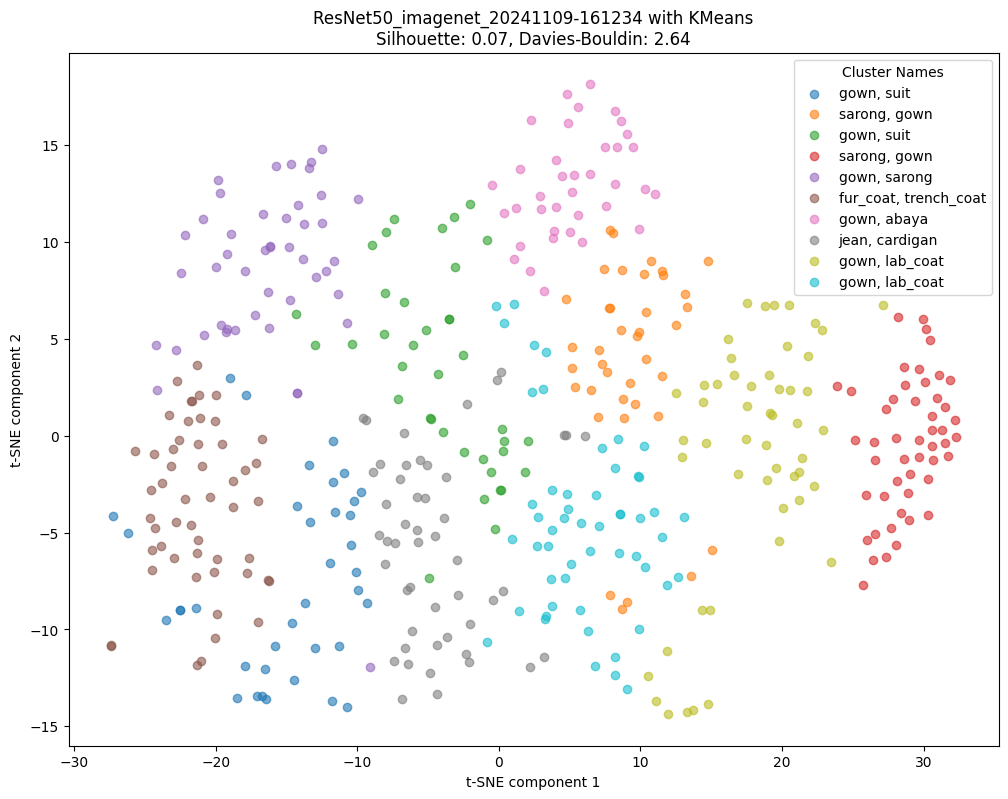

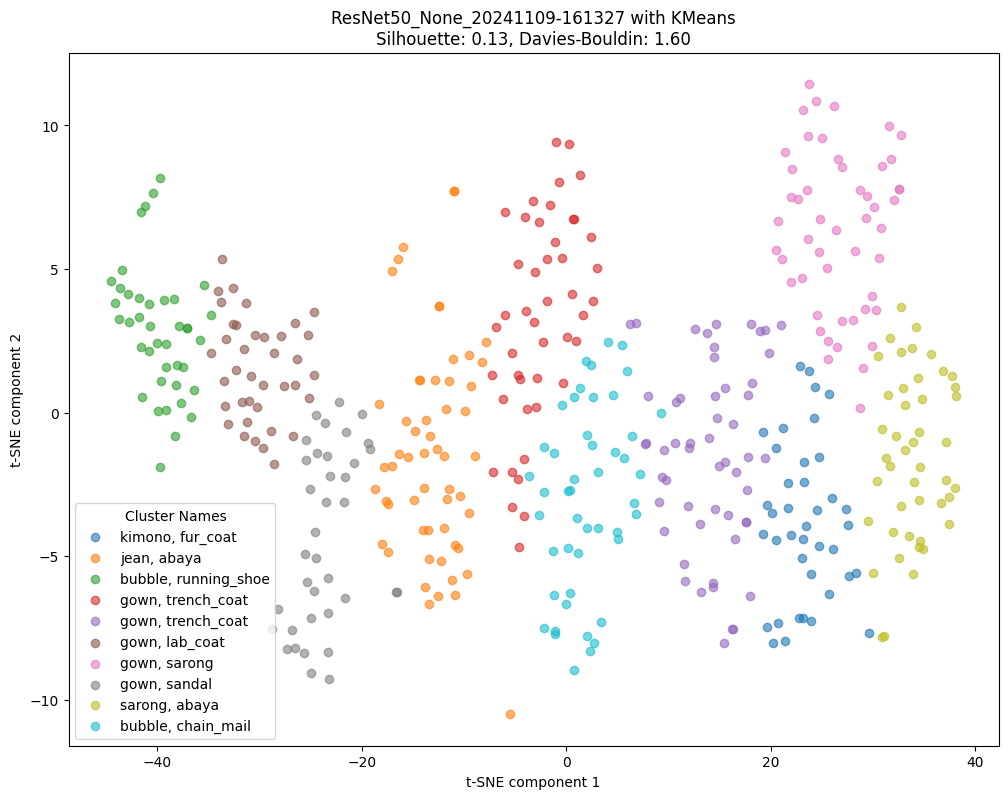

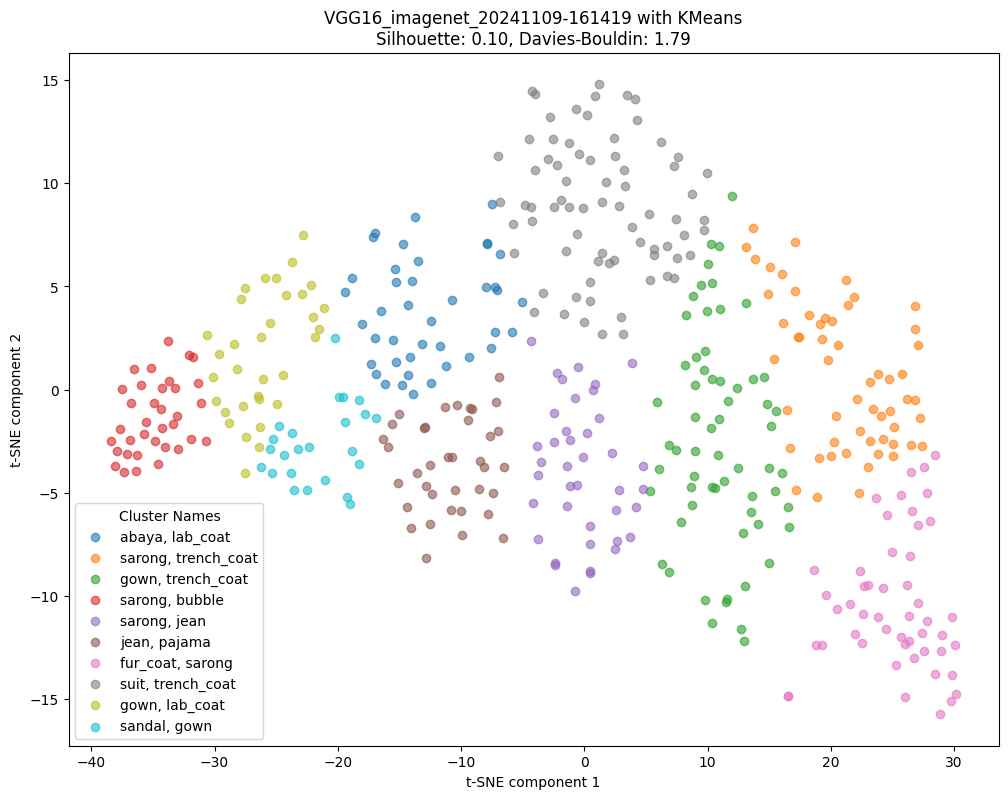

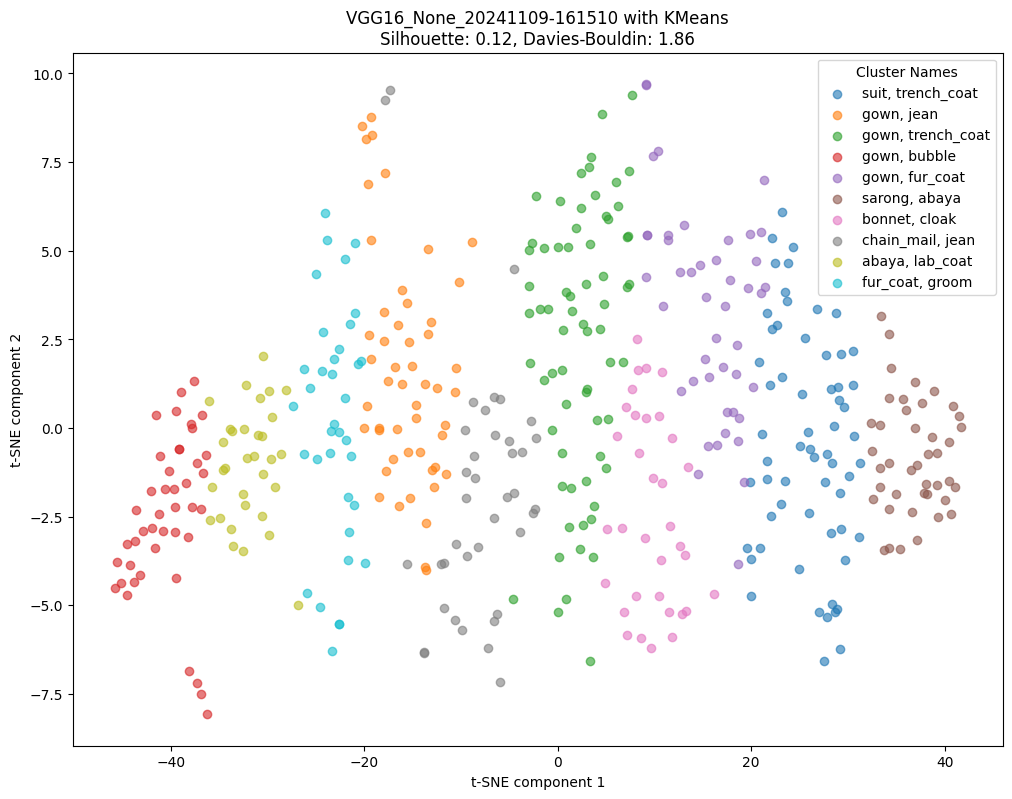

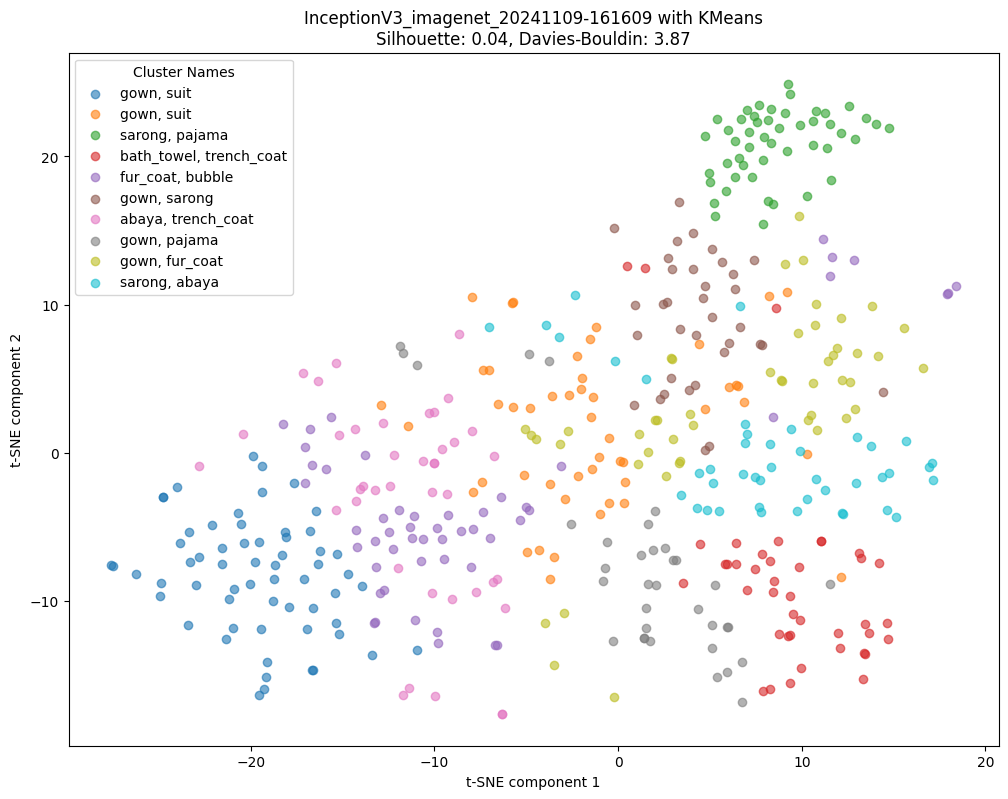

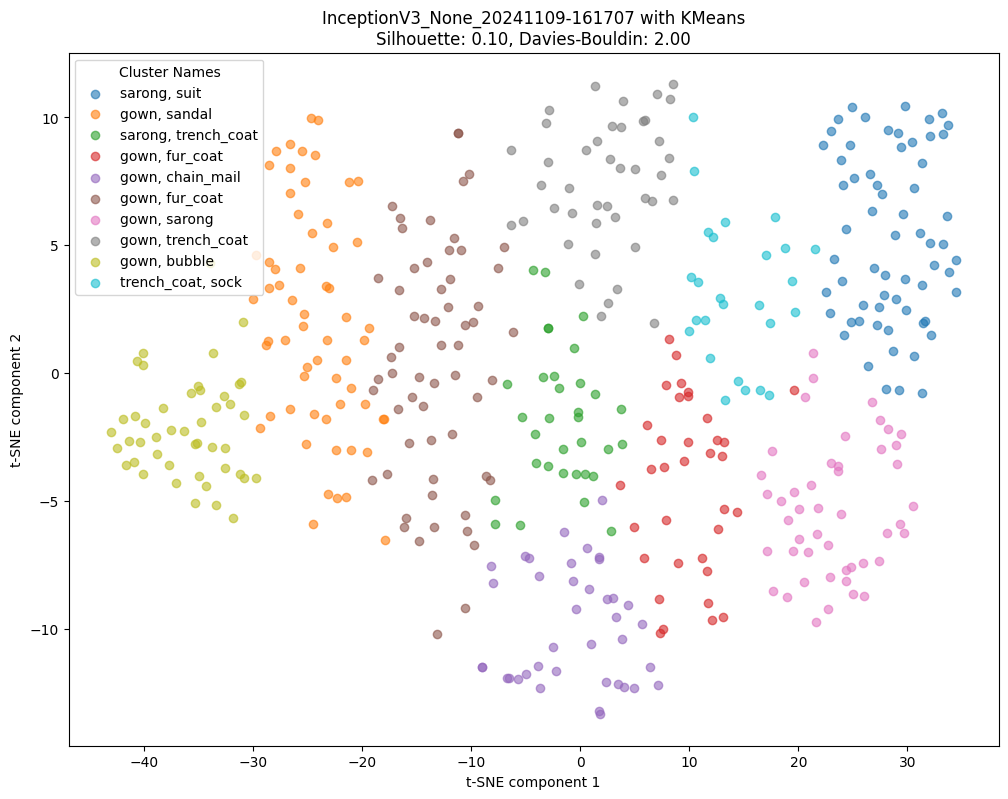

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from glob import glob
import os

# Define directories
output_dir = '/content/drive/MyDrive/clustering_results_3/'
features_dir = '/content/drive/MyDrive/results_2b/'

# Load saved clustering files
features_files = glob(f'{features_dir}*_features.npy')
print("Feature files detected for visualization:", features_files)

def visualize_clusters_with_legend(features, labels, cluster_names, title="Clustering Visualization", silhouette=None, davies_bouldin=None):
    tsne_results = TSNE(n_components=2).fit_transform(features)
    plt.figure(figsize=(12, 9))

    for cluster_label, cluster_name in cluster_names.items():
        cluster_points = tsne_results[labels == cluster_label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_name, alpha=0.6)

    score_text = f"{title}\nSilhouette: {silhouette:.2f}, Davies-Bouldin: {davies_bouldin:.2f}" if silhouette and davies_bouldin else title
    plt.legend(title="Cluster Names")
    plt.title(score_text)
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.show()

# Visualization for each saved clustering result
for feature_file in features_files:
    model_name = os.path.basename(feature_file).split('_features')[0]

    # Load features, labels, and cluster names using `_PCA50` suffix
    features = np.load(feature_file)
    labels_file = f"{output_dir}{model_name}_PCA50_labels.npy"
    cluster_names_file = f"{output_dir}{model_name}_PCA50_cluster_names.npy"

    if not os.path.exists(labels_file) or not os.path.exists(cluster_names_file):
        print(f"Missing files for {model_name}, skipping visualization.")
        continue

    labels = np.load(labels_file)
    cluster_names = np.load(cluster_names_file, allow_pickle=True).item()

    # Calculate clustering evaluation metrics
    silhouette = silhouette_score(features, labels) if len(set(labels)) > 1 else None
    davies_bouldin = davies_bouldin_score(features, labels) if len(set(labels)) > 1 else None

    # Visualize clusters with scores in the title
    visualize_clusters_with_legend(features, labels, cluster_names,
                                   title=f"{model_name} with KMeans",
                                   silhouette=silhouette,
                                   davies_bouldin=davies_bouldin)
